In [1]:
import jax3dp3 as j
import os
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
import jax

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


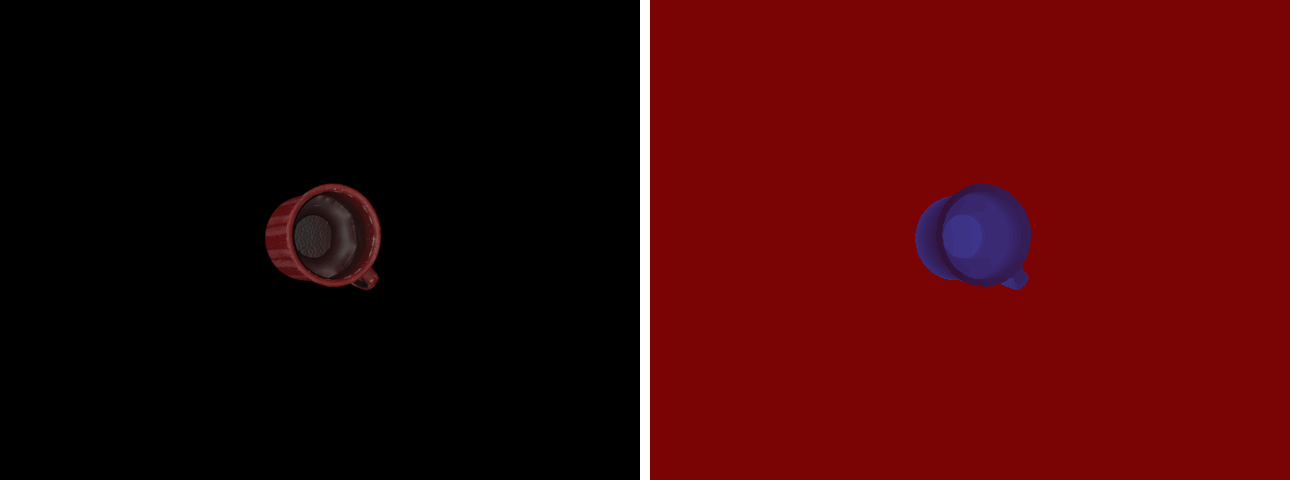

In [28]:
dataset_idx = 0
scene_idx = 2

dataset_filename = f"dataset_{dataset_idx}.npz"  # npz file
dataset_file = os.path.join(j.utils.get_assets_dir(), f"datasets/{dataset_filename}")
dataset = np.load(dataset_file, allow_pickle=True)
num_scenes_in_dataset = len(dataset['rgbds'])

rgbd = dataset['rgbds'][scene_idx]
gt_pose = dataset['poses'][scene_idx]
gt_name = str(dataset['name'])
gt_idx = int(dataset['id'])

j.hstack_images([j.get_rgb_image(rgbd.rgb), j.get_depth_image(rgbd.depth)])

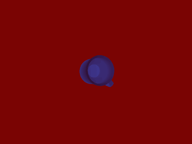

In [70]:
SCALING_FACTOR = 0.3
intrinsics = j.camera.scale_camera_parameters(rgbd.intrinsics, SCALING_FACTOR)

In [32]:
renderer = j.Renderer(intrinsics, num_layers=25)
model_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv/models")
model_names = ["obj_" + f"{str(idx+1).rjust(6, '0')}.ply" for idx in range(21)]
mesh_paths = []
for name in model_names:
    mesh_path = os.path.join(model_dir,name)
    mesh_paths.append(mesh_path)
    model_scaling_factor = 1.0/1000.0
    renderer.add_mesh_from_file(
        mesh_path,
        scaling_factor=model_scaling_factor
    )


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (192, 160, 25)


In [36]:
image = rgbd    
intrinsics = renderer.intrinsics
depth_scaled =  j.utils.resize(image.depth, intrinsics.height, intrinsics.width)
obs_point_cloud_image = j.t3d.unproject_depth(depth_scaled, intrinsics)
seg_scaled = j.utils.resize(image.segmentation, intrinsics.height, intrinsics.width)

In [37]:
grid_widths = [0.1, 0.05, 0.03, 0.03, 0.01, 0.05]
rot_angle_widths = [jnp.pi, jnp.pi, jnp.pi/1.5, 0.000001, jnp.pi/2.5, 0.0000001]
sphere_angle_widths = [jnp.pi, jnp.pi/6, jnp.pi/7, 0.000001, jnp.pi/8, 0.0000001]
grid_params =  [(3,3,3,75*5,61), (3,3,3,45,21),(3,3,3,45,21), (11,11,11,1,1), (3,3,3,45,21),(11,11,11,1,1)]  # (num_x, num_y, num_z, num_fib_sphere, num_planar_angle)
scheds = j.c2f.make_schedules(
    grid_widths=grid_widths, 
    angle_widths=rot_angle_widths, 
    grid_params=grid_params, 
    full_pose=True, 
    sphere_angle_widths=sphere_angle_widths
)


In [38]:
MAX_BATCH_SIZE = 1000
R_SWEEP = 0.1
OUTLIER_PROB=0.001
OUTLIER_VOLUME = 1000.0**3
K = 5

center = jnp.mean(obs_point_cloud_image[obs_point_cloud_image[:,:,2] < renderer.intrinsics.far],axis=0)
pose_estimate = j.t3d.transform_from_pos(center)
hypotheses = [(pose_estimate, -jnp.inf)]

for (sched_iteration, deltas) in enumerate(scheds):
    print("Schedule Iteration: ", sched_iteration)
    all_weights = []
    all_pose_proposals = []
    for hypo in hypotheses:
        pose_hyp = hypo[0]
        pose_proposals = jnp.einsum('ij,ajk->aik', pose_hyp, deltas)
        for pose_proposals_batch in tqdm(jnp.array_split(
            pose_proposals, np.ceil(pose_proposals.shape[0] / MAX_BATCH_SIZE).astype(int))):
            rendered = renderer.render_parallel(pose_proposals_batch, 13)
            weights = j.threedp3_likelihood_parallel_jit(
                obs_point_cloud_image, rendered, 
                R_SWEEP, OUTLIER_PROB, OUTLIER_VOLUME, 3
            )
            all_weights.append(weights)
            all_pose_proposals.append(pose_proposals_batch)

    all_weights = jnp.concatenate(all_weights)
    all_pose_proposals = jnp.concatenate(all_pose_proposals)
    assert len(all_weights) == len(all_pose_proposals)

    _, indices = jax.lax.top_k(all_weights, K)
    hypotheses = [
        (all_pose_proposals[idx], all_weights[idx]) for idx in indices
    ]


    rerendered_images = [
        renderer.render_single_object(hypo[0],13) for hypo in hypotheses
    ]
    images = [
        j.get_depth_image(img[:,:,2]) for img in rerendered_images
    ]
    j.hstack_images(images)


Schedule Iteration:  0


100%|██████████| 628/628 [02:02<00:00,  5.11it/s]


Schedule Iteration:  1


100%|██████████| 26/26 [00:05<00:00,  5.13it/s]


Schedule Iteration:  2


100%|██████████| 26/26 [00:05<00:00,  5.13it/s]


Schedule Iteration:  3


100%|██████████| 2/2 [00:00<00:00,  7.89it/s]


Schedule Iteration:  4


100%|██████████| 26/26 [00:05<00:00,  5.11it/s]


Schedule Iteration:  5


100%|██████████| 2/2 [00:00<00:00,  7.90it/s]


In [39]:
print(j.threedp3_likelihood_jit(
    obs_point_cloud_image, renderer.render_single_object(jnp.array(gt_pose),13)[:,:,:3], 
    R_SWEEP, OUTLIER_PROB, OUTLIER_VOLUME, 3
))
print([i[1] for i in hypotheses])
j.utils.normalize_log_scores(np.array([i[1] for i in hypotheses]))

-156946.23
[Array(-156952.17, dtype=float32), Array(-156953.25, dtype=float32), Array(-156953.28, dtype=float32), Array(-156953.66, dtype=float32), Array(-156954.4, dtype=float32)]


Array([0.5028316 , 0.17107983, 0.16581625, 0.11396373, 0.05383266],      dtype=float32)

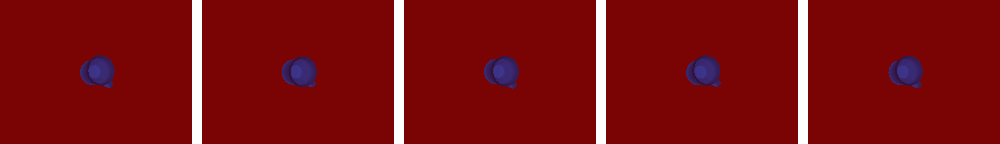

In [67]:
rerendered_images = [
    renderer.render_single_object(hypo[0],13) for hypo in hypotheses
]
images = [
    j.get_depth_image(img[:,:,2]) for img in rerendered_images
]

gt_img = j.get_depth_image(renderer.render_single_object(jnp.array(gt_pose), 13)[:,:,2], max=1.5)
gt_images = [
    gt_img for _ in rerendered_images
]


render_stack = j.hstack_images(images)
gt_stack = j.hstack_images(gt_images)
render_stack


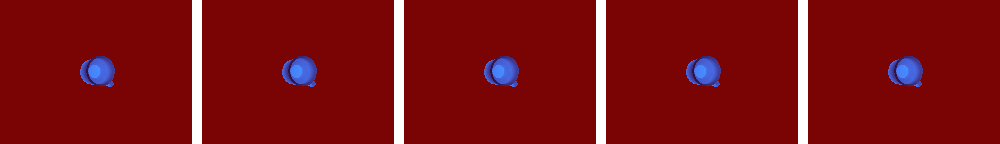

In [68]:
# j.meshcat.setup_visualizer()
# j.meshcat.show_cloud("1", obs_point_cloud_image[:,:,:3].reshape(-1,3))
# j.meshcat.show_cloud("2", rerendered_images[0][:,:,:3].reshape(-1,3),color=j.RED)
# j.hstack_images(images)

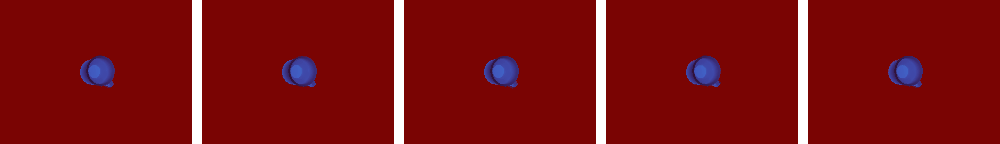

In [69]:
j.overlay_image(render_stack, gt_stack, alpha=0.5)


In [48]:
renderer.render_single_object(jnp.array(gt_pose), 13)

Array([[[-0.89990616, -0.6749296 ,  3.        ,  0.        ],
        [-0.89053214, -0.6749296 ,  3.        ,  0.        ],
        [-0.88115805, -0.6749296 ,  3.        ,  0.        ],
        ...,
        [ 0.8717841 , -0.6749296 ,  3.        ,  0.        ],
        [ 0.88115805, -0.6749296 ,  3.        ,  0.        ],
        [ 0.89053214, -0.6749296 ,  3.        ,  0.        ]],

       [[-0.89990616, -0.6655556 ,  3.        ,  0.        ],
        [-0.89053214, -0.6655556 ,  3.        ,  0.        ],
        [-0.88115805, -0.6655556 ,  3.        ,  0.        ],
        ...,
        [ 0.8717841 , -0.6655556 ,  3.        ,  0.        ],
        [ 0.88115805, -0.6655556 ,  3.        ,  0.        ],
        [ 0.89053214, -0.6655556 ,  3.        ,  0.        ]],

       [[-0.89990616, -0.6561816 ,  3.        ,  0.        ],
        [-0.89053214, -0.6561816 ,  3.        ,  0.        ],
        [-0.88115805, -0.6561816 ,  3.        ,  0.        ],
        ...,
        [ 0.8717841 , -0.65

In [50]:
pose_hyp = hypotheses[0][0]

In [59]:

all_weights = []
all_pose_proposals = []
pose_proposals = jnp.einsum('ij,ajk->aik', pose_hyp, deltas)
for pose_proposals_batch in tqdm(jnp.array_split(
    pose_proposals, np.ceil(pose_proposals.shape[0] / MAX_BATCH_SIZE).astype(int))):
    rendered = renderer.render_parallel(pose_proposals_batch, 13)
    weights = j.threedp3_likelihood_parallel_jit(
        obs_point_cloud_image, rendered, 
        R_SWEEP, OUTLIER_PROB, OUTLIER_VOLUME, 3
    )
    all_weights.append(weights)
    all_pose_proposals.append(pose_proposals_batch)

all_weights = jnp.concatenate(all_weights)
all_pose_proposals = jnp.concatenate(all_pose_proposals)
assert len(all_weights) == len(all_pose_proposals)

best_idx = jnp.argmax(all_weights)
pose_hyp = all_pose_proposals[best_idx]
print(all_weights[best_idx])

100%|██████████| 125/125 [00:05<00:00, 22.05it/s]

-157198.9


In [60]:
(gt_pose - pose_hyp)[:3,3]

Array([2.2463500e-05, 1.7610774e-04, 8.0003142e-03], dtype=float32)

In [61]:
j.meshcat.show_cloud("1", obs_point_cloud_image[:,:,:3].reshape(-1,3))
j.meshcat.show_cloud("2", renderer.render_single_object(pose_hyp, 13)[:,:,:3].reshape(-1,3),color=j.RED)

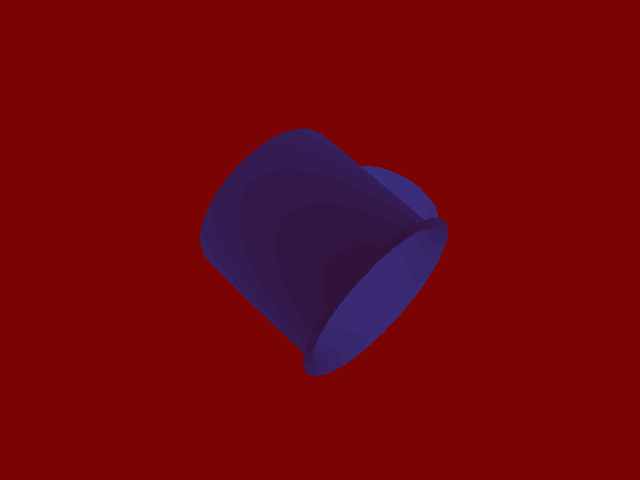

In [12]:
j.get_depth_image(rgbd.depth)

In [22]:
j.meshcat.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [27]:
hypotheses[0][0] - gt_pose

Array([[-0.03331858,  0.10476795, -0.00879008,  0.00128951],
       [ 0.00423849,  0.05463201,  0.05569148,  0.00081704],
       [ 0.03954846, -0.00792277,  0.10076526, -0.01824656],
       [ 0.        ,  0.        ,  0.        ,  0.        ]],      dtype=float32)

In [16]:
gt_pose

array([[ 0.68066406,  0.22265625,  0.6977539 ,  0.00691486],
       [-0.4296875 , -0.6503906 ,  0.62646484, -0.00295594],
       [ 0.5932617 , -0.7260742 , -0.34692383,  0.50382346],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [13]:
j.utils.normalize_log_scores(np.array([i[1] for i in hypotheses]))

Array([9.8449647e-01, 1.8749982e-02, 1.7026029e-07, 6.7197824e-08,
       3.6458092e-09], dtype=float32)

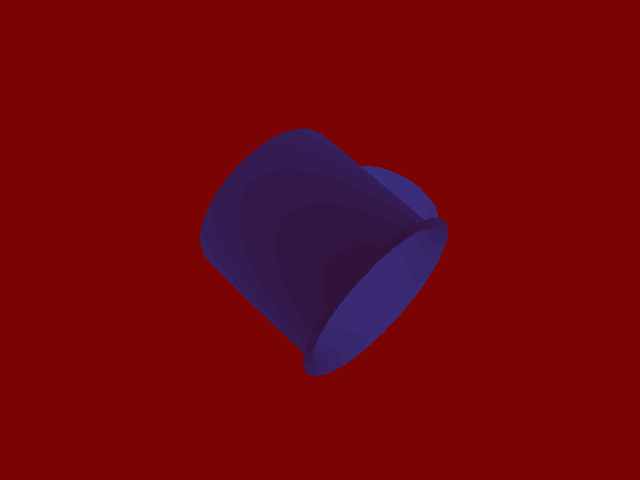